# Deep Learning Tutorial

Deep Learning Tutorial based on https://spandan-madan.github.io/DeepLearningProject/.

Credits: [Spandan Madan](http://people.csail.mit.edu/smadan/web/).

## Imports

* In this section we import required packages.

In [1]:
# Inline figures
%matplotlib inline

* We can install these packages using the notebook itself using [Jake Van Der Plas](http://jakevdp.github.io) blog post on [Installing Python packages on a Jupyter Notebook](http://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/).

In [2]:
# Installing Python packages from the notebook
# import sys
#!conda install -c conda-forge --yes --prefix {sys.prefix} urllib2 # did not work cause of Python 2
# Change to python 3 by using urllib instead
#!{sys.executable} -m pip install urllib2 # did not work cause of Python 2
#!conda install -c conda-forge --yes --prefix {sys.prefix} wget # did not work
#!{sys.executable} -m pip install wget # worked
#!{sys.executable} -m pip install imdb # did not work
#!{sys.executable} -m pip install IMDbPY # worked

In [3]:
# Web access packages
import urllib
import requests
import wget

# Utilities packages
import itertools
import time
import os
import json
import logging

# Movies database API packages
import imdb 
import tmdbsimple as tmdb


import numpy as np
import random as rd

# Figure and style packages
import matplotlib.pyplot as plt
import seaborn as sns

# Object serialization package
import pickle

# Custom utility functions
# TMDB
from dltutorial.utils import get_movie_id_tmdb
from dltutorial.utils import get_movie_info_tmdb
from dltutorial.utils import get_movie_genres_tmdb
from dltutorial.utils import get_api_key_tmdb
from dltutorial.utils import get_movie_poster_tmdb

# IMDB
from dltutorial.utils import get_movie_info_imdb
from dltutorial.utils import get_movie_genres_imdb

# Importing relevant scikit-learn package
from sklearn.metrics import classification_report

## Style

In [4]:
plt.style.use('seaborn-darkgrid')
sns.set(rc={'figure.figsize':(9, 6)})

## Logging

* Here we instanciate a logging object to record our logs.

In [5]:
logging.basicConfig(filename="./dltutorial/logs/dev_logs.txt",
                    level=logging.INFO, # set to any level. INFO hides DEBUG output.
                    format=' %(asctime)s - %(funcName)s -'
                    '%(levelname)s - %(message)s')

## Utility functions

* You may want to create a private Python module containing only an ``__init__.py`` file that consists in a string variable ``API_KEY`` that is your private API key from [TMDB](https://www.themoviedb.org/). Else you can instanciate the ``api_key`` directly in your notebook but do not share it!

* Custom utility functions have been implemented in ``dltutorial.utils``.

* We create a folder where we store the scrapped movie posters.

In [6]:
logging.info('Setting posters storage folder...')

# Create a posters folder inside data folder
posters_path = './dltutorial/data/posters/'

        
if not os.path.exists(posters_path):
    logging.debug('%s does not exists. Creating relevant folders...' %
                 posters_path)
    # Recursive folder creation
    os.makedirs(posters_path)
else:
    logging.debug('%s already exists...' % posters_path)
    print('%s already exists...' % posters_path)

./dltutorial/data/posters/ already exists...


## Exploring Movies Database API

### TMDB

In [7]:
logging.info('Setting TMDB API key...')
if 'private' in os.listdir('./dltutorial'): #
    logging.debug('Private folder exists...')
    from dltutorial import private
    api_key = private.API_KEY
else:
    logging.debug('No private folder found...')
    print('There is no private folder.'
          'API key will remain blank if you do not set it.')
    api_key = '' # put your own API key but do not share it
# Set the TMDB API key
tmdb.API_KEY = api_key 
logging.debug('TMDB API key is set to %s...' % api_key) # Do not share the logs folder in dltutorial

# Instanciate a search object from TMDB
search_tmdb = tmdb.Search()

# Some examples
movie_name = "The Matrix"

movie_id = get_movie_id_tmdb(movie_name=movie_name, search_tmdb=search_tmdb)
print("%s has id %s\n" % (movie_name, movie_id))
movie_info = get_movie_info_tmdb(movie_name=movie_name, search_tmdb=search_tmdb)
print("%s has these info categories:\n %s\n" % (movie_name, list(movie_info.keys())))
movie_genres = get_movie_genres_tmdb(movie_name=movie_name, search_tmdb=search_tmdb)
print("%s belongs to these genres:\n %s\n" % (movie_name, movie_genres))

The Matrix has id 603

The Matrix has these info categories:
 ['original_language', 'release_date', 'runtime', 'spoken_languages', 'budget', 'original_title', 'poster_path', 'vote_count', 'overview', 'popularity', 'revenue', 'id', 'title', 'vote_average', 'genres', 'backdrop_path', 'imdb_id', 'production_companies', 'belongs_to_collection', 'adult', 'video', 'tagline', 'homepage', 'status', 'production_countries']

The Matrix belongs to these genres:
 [{'id': 28, 'name': 'Action'}, {'id': 878, 'name': 'Science Fiction'}]



### IMDB

In [9]:
movie_name = "The Matrix"
search_imdb = imdb.IMDb()

movie_genres = get_movie_genres_imdb(movie_name=movie_name, search_imdb=search_imdb)
print("%s movie belongs to genres:\n %s \n" % (movie_name, movie_genres))
movie_info = get_movie_info_imdb(movie_name=movie_name, search_imdb=search_imdb)
print("%s movie first 10 info categories:\n %s \n" % (movie_name, movie_info.keys()[:10]))

The Matrix movie belongs to genres:
 ['Action', 'Sci-Fi'] 

The Matrix movie first 10 info categories:
 ['casting department', 'rating', 'special effects companies', 'assistant director', 'art department', 'miscellaneous crew', 'camera and electrical department', 'plot outline', 'runtimes', 'sound crew'] 



## Multiple movies

#### Top 20 from TMDB

In [10]:
genres_dict_file = './dltutorial/data/genres_dict.pckl'

# Top 20 popular films
top_movies = tmdb.Movies().popular()['results']
# Create a TMDB genre object
genres = tmdb.Genres()
# Returns the genres list (ID/name)
genres_list = genres.movie_list()['genres']

# if genres dictionary does not exists
if not os.path.exists(genres_dict_file):
    # Create a genres dictionary mapping a genre ID to its name
    genres_dict = dict()
    for genre in genres_list:
        genres_dict[genre['id']] = genre['name']
    logging.debug("Writing genres dict on hard disk...")
    with open(genres_dict_file, 'wb') as f:
        pickle.dump(genres_dict, f)
    logging.debug("Done saving genres dict in %s..." %
                 genres_dict_file)
# Else load existing one
else:
    logging.debug("Loading genres dict from hard disk...")
    with open(genres_dict_file, 'rb') as f:
        genres_dict = pickle.load(f)
    logging.debug("Done loading genres dict from %s..." %
                 genres_dict_file)


# Print the genres of top 5 movies
for movie in top_movies[:5]:
    genre_ids = movie['genre_ids']
    genre_names = [genres_dict[genre_id] for genre_id in genre_ids]
    print("%s\n%s\n" % (movie['title'], genre_names))

Avengers: Infinity War
['Adventure', 'Science Fiction', 'Fantasy', 'Action']

Dirty Dead Con Men
['Action', 'Crime', 'Drama']

Fifty Shades Freed
['Drama', 'Romance']

Black Panther
['Action', 'Adventure', 'Fantasy', 'Science Fiction']

Deadpool 2
['Action', 'Comedy', 'Science Fiction']



#### Top 1000 movies from TMDB

In [11]:
movie_list_file = './dltutorial/data/tmdb_movie_list.pckl'

if not os.path.exists(movie_list_file):
    # Instantiate TMDB movies object
    all_movies = tmdb.Movies()
    # Instantiate empty list of movies to populate
    top1000_movies = list()
    # Number of pages to download
    n_pages = 50
    logging.debug("Downloading movie list from top %s pages..." % n_pages)
    for i in range(1, n_pages + 1):
        if i % 10 == 0:
            msg = "%s out of %s movie pages downloaded (%s%%)..." % (i, n_pages,
                                                    round(100 * i / n_pages, 1))
            print(msg)
            logging.debug(msg)
            time.sleep(5)
        current_page_movies = all_movies.popular(page=i)['results']
        top1000_movies.extend(current_page_movies)
    # Write binary in data folder in pickle format
    logging.debug("Writing %s movie results on disk..." % (len(top1000_movies)))
    with open(file=movie_list_file, mode='wb') as f:
        pickle.dump(top1000_movies, f)
    logging.debug("Done writing...")
else:
    # Open binary pickle file to load movie list variable
    logging.debug("Loading movies list from disk...")
    with open(file=movie_list_file, mode='rb') as f:
        top1000_movies = pickle.load(f)
    logging.debug("Done loading %s movies" % len(top1000_movies))

## Dealing with an unbalanced dataset

Handling the multi-label component. Co-occurrence sheds some information on whether the dataset has imbalances.

* We want to investigate pairwise genres correlations.
    * First we build every possible pair from the movie genres available.

In [12]:
def list2pairs(input_list):
    """
    Generating all possible pairs of movies
    
    Parameters
    -----------
    - input_list: list
        generic list used to generate pairs
        
    Returns
    -----------
    - pairs: list
        list of pairs (tuples)
    """
    # Build all pairs of length 2 from input_list
    pairs = list(itertools.combinations(input_list, 2))
    # Add duplicate pairs
    pairs.extend([(elt, elt) for elt in input_list])
    return pairs

##### Debugging part: dropping missing genre

In [13]:
# Get all genre pairs from top 1000 movies
genre_pairs = list()
for movie in top1000_movies:
    genre_pairs.extend(list2pairs(movie['genre_ids']))
    
# We keep only unique pairs
unique_genres = np.unique(genre_pairs)
# We instantiate a correlation matrix
corr_matrix = np.zeros((len(unique_genres), len(unique_genres)))
for pair in genre_pairs:
    corr_matrix[np.argwhere(unique_genres == pair[0]),
                np.argwhere(unique_genres == pair[1])] += 1
    # If not duplicate pairs, affect symmetrical coefficient
    if pair[1] != pair[0]:
        corr_matrix[np.argwhere(unique_genres == pair[1]),
                    np.argwhere(unique_genres == pair[0])] += 1
    
# Handling missing genres
#try:
#    assert len(genres_dict.keys()) == corr_matrix.shape[0]
#except:
#    print("Number of genres from TMDB %d" % len(genres_dict.keys()))
#    print("Correlation matrix shape: ", corr_matrix.shape)
#    missing_genres = [genre for genre in list(genres_dict.keys()) if genre not in unique_genres]
#    for genre in missing_genres:
#        print("Removing genre %s from genres dictionary..." % genres_dict[genre])
#        genres_dict.pop(genre, None)
#    assert len(genres_dict.keys()) == corr_matrix.shape[0]
#    assert len(genres_dict.keys()) == corr_matrix.shape[1]

#### Correlation matrix visualization

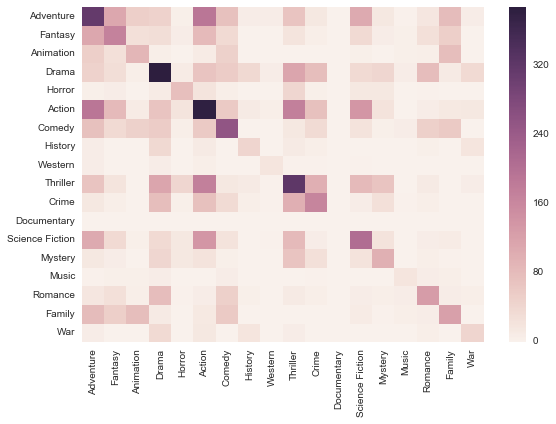

In [14]:
# Return genres names
annotations = [genres_dict[genre_id] for genre_id in unique_genres]
# Display correlation matrix
sns.heatmap(corr_matrix, xticklabels=annotations, yticklabels=annotations);

* Diagonal terms correspond to self-pairs, i.e. the number of times a genre co-occur. That is nothing else than the total times said genre occurred. *We observe that Drama seems to be the most common genre*.

* Additionally we notice that Action often occurs alongside Adventure, Thriller and Science Fiction.

### Clustering

* In this section we use [Spectral Clustering](https://en.wikipedia.org/wiki/Spectral_clustering) to cluster the most similar genres. Spectral Clustering essentially performs a dimensionality reduction based on the similarity matrix eigenvalues to then cluster in lower dimensions (often using K-Means).

In [15]:
from sklearn.cluster import SpectralCoclustering

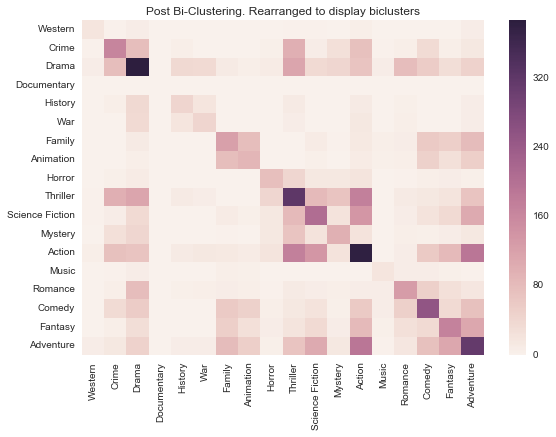

In [16]:
# Instantiate model
model = SpectralCoclustering(n_clusters=7, random_state=42)
# Fit model
model.fit(corr_matrix)

# Rearrange data based on bi-clusters
fit_data = corr_matrix[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

# Build rearranged annotations
sorted_annotations = [genres_dict[unique_genres[idx]] for idx in np.argsort(model.row_labels_)]

# Display biclustering aftermath
sns.heatmap(fit_data, xticklabels=sorted_annotations, yticklabels=sorted_annotations)
plt.title("Post Bi-Clustering. Rearranged to display biclusters");

* We see genres are clustered into groups (7 here). For instance: *Drama* and *Crime* belong to one cluster while *Family* and *Animation* belong to another one.

* Note that there is some randomness involved in the clustering process. For this reason we set the random seed.

* The clustering will vary if you change the number of cluster. Note that the *correctness* of the clustering is hard to assess.

* We may use this clustering to reduce the number of genres to *meta genres* and therefore achieve a higher accuracy.

## Scrapping TMDB movies

* In this section we retrieve the information on each movie we selected previously.

* Note that the download can take a while.

In [17]:
genre_movies_list_file = './dltutorial/data/tmdb_genre_movies_list.pckl'

if not os.path.exists(genre_movies_list_file):
    # Instantiate empty movies list
    genre_movies = list()
    # Set base year to prevent duplicates
    # We decrement the base_year for every genre,
    # increasing our chances to encounter duplicate movies
    base_year = 2017
    # Set number of pages to download per genre
    n_pages_per_genre = 5
    print("Start downloading...")
    logging.debug("Starting downloading movies from TMDB."
                 "Each genre will download %d movies..." %
                  (20 * n_pages_per_genre))
    for genre_id in unique_genres:
        logging.debug("Downloading movies from genre %s..." %
                     genres_dict[genre_id])
        print("Downloading movies from genre %s..." %
                     genres_dict[genre_id])
        # Decrement base_year. Described above
        base_year -= 1
        for page_id in range(1, n_pages_per_genre + 1):
            # Let TMDB server have some rest
            time.sleep(0.5)
            # Setting URL using parameters
            url = 'https://api.themoviedb.org/3/discover/movie?api_key=' + api_key
            url += '&language=en-US&sort_by=popularity.desc&year=' + str(base_year)
            url += '&with_genres=' + str(genre_id) + '&page=' + str(page_id)
            # Retrieve results
            data = urllib.request.urlopen(url).read().decode('utf8')
            # Append results to genre_movies
            genre_movies.extend(json.loads(data)["results"])
    print("Done downloading...")

    # Write binary in data folder in pickle format
    logging.debug("Writing %s movie results on disk..." % (len(genre_movies)))
    with open(file=genre_movies_list_file, mode='wb') as f:
        pickle.dump(genre_movies, f)
    logging.debug("Done writing...")
else:
    # Open binary pickle file to load movie list variable
    logging.debug("Loading movies list from disk...")
    with open(file=genre_movies_list_file, mode='rb') as f:
        genre_movies = pickle.load(f)
    logging.debug("Done loading %s movies..." % len(genre_movies))

#### Removing duplicates

* Our scrapping was not able to prevent downloading duplicates. We remove them at this stage.

In [18]:
# Instantiate empty id list
seen_ids = list()
# Instantiate empty movie list
unique_movies = list()
logging.debug("Originally we had %s movies..." % len(genre_movies))
print("Originally we had %s movies..." % len(genre_movies))
for movie in genre_movies:
    movie_id = movie['id']
    if movie_id in seen_ids:
        continue
    else:
        seen_ids.append(movie_id)
        unique_movies.append(movie)
# Assert if we rightfully removed duplicates
assert len(unique_movies) == len(np.unique([movie['id'] for movie in genre_movies]))
logging.debug("After removing duplicates we have %s movies..."
              % len(unique_movies))
print("Now we have %s movies..." % len(unique_movies))

Originally we had 1676 movies...
Now we have 1597 movies...


#### Poster and posterless movies

* Here we create two lists based on whether the movie has a poster or not.

In [19]:
poster_movies_list_file = './dltutorial/data/posters/poster_movies_list.pckl'
posterless_movies_list_file = './dltutorial/data/posters/posterless_movies_list.pckl'

if not os.path.exists(poster_movies_list_file) or not os.path.exists(posterless_movies_list_file):
    # Instantiate empty lists
    poster_movies = list()
    posterless_movies = list()

    logging.debug("Starting downloading posters for %s movies..." %
                 len(unique_movies))
    print("Starting downloading posters for %s movies..." %
                 len(unique_movies))
    for counter, movie in enumerate(unique_movies):
        # Keep track of current progress
        if counter % 400 == 0 and counter != 0:
            print("%d movies downloaded (%s%%)" %
                  (counter, round(100 * counter / len(unique_movies))))
            logging.debug("%d movies downloaded (%s%%)" %
                  (counter, round(100 * counter / len(unique_movies))))
        # Try getting the poster
        try:
            get_movie_poster_tmdb(movie['title'], search_tmdb=search_tmdb, path=complete_path)
            poster_movies.append(movie)
        # If too many requests, wait
        except:
            try:
                time.sleep(7)
                get_movie_poster_tmdb(movie['title'], search_tmdb=search_tmdb, path=complete_path)
                poster_movies.append(movie)
            # If poster is missing, movie is posterless
            except:
                posterless_movies.append(movie)
    logging.debug("Done downloading. %d with poster. %d posterless" %
                 (len(poster_movies), len(posterless_movies)))
    print("Done downloading. %d with poster. %d posterless" %
                 (len(poster_movies), len(posterless_movies)))
    
    # Write binary in data folder in pickle format
    logging.debug("Writing %s poster movies results on disk..." % (len(poster_movies)))
    with open(file=poster_movies_list_file, mode='wb') as f:
        pickle.dump(poster_movies, f)
    logging.debug("Done writing...")
    logging.debug("Writing %s posterless movies results on disk..." % (len(posterless_movies)))
    with open(file=posterless_movies_list_file, mode='wb') as f:
        pickle.dump(posterless_movies, f)
    logging.debug("Done writing...")
    
else:
    # Open binary pickle file to load movie list variable
    logging.debug("Loading poster movies list from disk...")
    with open(file=poster_movies_list_file, mode='rb') as f:
        poster_movies = pickle.load(f)
    logging.debug("Done loading %s poster movies..." % len(poster_movies))
    print("Done loading %s poster movies..." % len(poster_movies))
    
    logging.debug("Loading posterless movies list from disk...")
    with open(file=posterless_movies_list_file, mode='rb') as f:
        posterless_movies = pickle.load(f)
    logging.debug("Done loading %s posterless movies..." % len(posterless_movies))
    print("Done loading %s posterless movies..." % len(posterless_movies))

Done loading 1591 poster movies...
Done loading 6 posterless movies...


## Building the dataset

* We stick with the original implementation first:
  * We will use 2 different kinds of features - text and images.
    * text: movie's overview available from TMDB.
    * image: movie's poster available from TMDB.
  * We will use multi-labels as targets.
  
  
* How to store movies overview in a matrix?

*Using a count vectorizer to store words with a *bag of words* representation.*

* How to avoid the curse of dimensionality?

*Using a TF-IDF to discard words either too frequent or too rare.*

In [20]:
targets_file = './dltutorial/data/targets_text.pckl'
inputs_file = './dltutorial/data/inputs_text.pckl'
overview_movies_file = './dltutorial/data/overview_movies.pckl'

if not os.path.exists(targets_file) or\
    not os.path.exists(inputs_file) or\
    not os.path.exists(overview_movies_file):
    # Picking movies with available overview
    overview_movies = [movie for movie in poster_movies if len(movie['overview']) > 0]
    print("%d movies have available overview..." % len(overview_movies))
    # Making an iterable of iterables (genre_ids)
    movie_genre_ids = [movie['genre_ids'] for movie in overview_movies]
    print("Movie genre sample:\n%s" % movie_genre_ids[1])
    from sklearn.preprocessing import MultiLabelBinarizer
    # Turning genre_ids into multi labels
    targets = MultiLabelBinarizer().fit_transform(movie_genre_ids)
    print("Multi-labels shape: %d by %d" % (targets.shape))
    logging.debug("Multi-labels shape: %d by %d" % (targets.shape))
    print("Genre counts:\n%s" % (np.sum(targets, axis=0)))
    # Get rid of the punctuation
    overviews = [movie['overview'].replace(',', '').replace('.', '') for movie in overview_movies]
    from sklearn.feature_extraction.text import CountVectorizer
    # min_df exclude words that occur very rarely
    # max_df exclude words that occur too often
    vectorizer = CountVectorizer(max_df=0.95, min_df=0.005)
    inputs = vectorizer.fit_transform(overviews)
    print("Inputs shape: %d by %d" % (inputs.shape))
    logging.debug("Inputs shape: %d by %d" % (inputs.shape))
    
    # Writing inputs in pickle format
    logging.debug("Writing %d inputs on disk..." % inputs.shape[0])
    with open(inputs_file, 'wb') as f:
        pickle.dump(inputs, f)
    logging.debug("Done writing inputs in %s..." % inputs_file)
    # Writing targets in pickle format
    logging.debug("Writing %d targets on disk..." % targets.shape[0])
    with open(targets_file, 'wb') as f:
        pickle.dump(targets, f)
    logging.debug("Done writing targets in %s..." % targets_file)
    # Writing overview movies in pickle format
    logging.debug("Writing %d overview movies on disk..." % len(overview_movies))
    with open(overview_movies_file, 'wb') as f:
        pickle.dump(overview_movies, f)
    logging.debug("Done writing overview movies in %s..." % overview_movies_file)
    
    
else:
    # Opening binary pickle to load inputs, targets and genres dictionary variables
    # Inputs
    logging.debug("Loading inputs from disk (%s)..." % inputs_file)
    with open(inputs_file, 'rb') as f:
        inputs = pickle.load(f)
    logging.debug("Done loading %s inputs..." % inputs.shape[0])
    # Targets
    logging.debug("Loading targets from disk (%s)..." % targets_file)
    with open(targets_file, 'rb') as f:
        targets = pickle.load(f)
    logging.debug("Done loading %s targets..." % targets.shape[0])
    # Overview movies
    logging.debug("Loading overview movies from disk (%s)..." % overview_movies_file)
    with open(overview_movies_file, 'rb') as f:
        overview_movies = pickle.load(f)
    logging.debug("Done loading %s overview movies..." % len(overview_movies))

* As we can see here, the data size is really small - around 1k samples.
For better results we need to scrap more data but this tutorial's goal is to get familiar with conventional ML and DL techniques.

## Conventional ML models

Overview:
* Implementing two models.
* Benchmarking the two models using a performance metric.
* Discussing the differences between the two models.

A lot of decisions can be made as this point. We can decide to use Non-Bayesian approaches, such as:
* Generalized Linear Models
* Support Vector Machines (SVM)
* Shallow Neural Network (only 1 layer)
* Random Forest / Decision Tree / Boosting

Or use Bayesian approaches:
* Naive Bayes
* Linear or Quadratic Discriminant Analysis
* Bayesian Hierarchical Models

For demonstration purposes we will pick one model out of both approaches.

### Features engineering

* We use TF-IDF to assign weight to every word in the bag of words - i.e. for each sample.

In [21]:
inputs_tfidf_file = './dltutorial/data/inputs_text_tfidf.pckl'

if not os.path.exists(inputs_tfidf_file):
    logging.debug("Using TF-IDF on inputs...")
    from sklearn.feature_extraction.text import TfidfTransformer
    inputs_tfidf = TfidfTransformer().fit_transform(inputs)
    logging.debug("TF-IDF done...")
    logging.debug("Writing TF-IDF inputs on disk...")
    with open(inputs_tfidf_file, 'wb') as f:
        pickle.dump(inputs_tfidf, f)
    logging.debug("Done writing TF-IDF inputs in %s..." %
                 inputs_tfidf_file)
    print("TF-IDF inputs shape: (%d, %d)" % inputs_tfidf.shape)
    
else:
    logging.debug("Loading TF-IDF inputs from disk (%s)..." % 
                 inputs_tfidf_file)
    with open(inputs_tfidf_file, 'rb') as f:
        inputs_tfidf = pickle.load(f)
    logging.debug("Done loading TF-IDF inputs...")
    print("TF-IDF inputs shape: (%d, %d)" % inputs_tfidf.shape)

TF-IDF inputs shape: (1577, 1353)


### Splitting the dataset into training and testing

In [22]:
# Setting the random seed
np.random.seed(seed=42)

X = inputs_tfidf
Y = targets

# Mask array
mask = np.random.rand(X.shape[0]) < 0.8

X_train = X[mask]
y_train = Y[mask]
X_test = X[~mask]
y_test = Y[~mask]

assert X_train.shape[0] > X_test.shape[0]
assert X_train.shape[1] == X_test.shape[1]
assert y_train.shape[0] > y_test.shape[0]
assert y_train.shape[1] == y_test.shape[1]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1251, 1353)
y_train shape: (1251, 19)
X_test shape: (326, 1353)
y_test shape: (326, 19)


In [23]:
# Create models folder
models_path = './dltutorial/models/'

if not os.path.exists(models_path):
    print("Created %s folder..." % models_path)
    logging.debug("Created %s folder..." % models_path)
    os.makedirs(models_path)
    
else:
    print("%s folder already exists..." % models_path)
    logging.debug("%s folder already exists..." % models_path)

./dltutorial/models/ folder already exists...


In [24]:
SVM_clf_file = './dltutorial/models/SVC.pckl'

if not os.path.exists(SVM_clf_file):
    logging.debug("Importing relevant scikit-learn packages...")
    # Scikit-learn imports
    from sklearn.multiclass import OneVsRestClassifier
    from sklearn.svm import SVC
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import f1_score
    from sklearn.metrics import make_scorer
    
    # Parameters grid
    param_grid = {'kernel':['linear'], 'C':[0.01, 0.1, 1.0]}
    # Grid-Search Cross Validation
    logging.debug("Grid-Search CV instantiation...")
    gridCV = GridSearchCV(SVC(class_weight='balanced'),
                          param_grid=param_grid,
                          scoring=make_scorer(f1_score, average='micro'))
    # Multi-label/class strategy
    logging.debug("Multi-label strategy classifier...")
    clf = OneVsRestClassifier(gridCV)
    # Fitting the classifier
    logging.debug("Fitting the classifier...")
    clf.fit(X_train, y_train)
    # Store the model
    logging.debug("Storing the classifier under %s..." %
                 SVM_clf_file)
    with open(SVM_clf_file, 'wb') as f:
        pickle.dump(clf, f)
    logging.debug("Done writing the classifier under %s..." %
                 SVM_clf_file)
    
else:
    logging.debug("Loading the classifier from %s..." %
                 SVM_clf_file)
    with open(SVM_clf_file, 'rb') as f:
        clf = pickle.load(f)
    logging.debug("Done loading the classifier from %s..." %
                 SVM_clf_file)    

In [25]:
# Importing relevant scikit-learn package
from sklearn.metrics import classification_report
# Predicting on test set
y_pred = clf.predict(X_test)
# Printing results
sorted_genre_names = [genres_dict[genre_id] for genre_id in sorted(genres_dict.keys())]
print(classification_report(y_test, y_pred, target_names=sorted_genre_names))

                 precision    recall  f1-score   support

      Adventure       0.39      0.55      0.46        74
        Fantasy       0.39      0.44      0.41        59
      Animation       0.40      0.40      0.40        63
          Drama       0.56      0.53      0.55       107
         Horror       0.38      0.49      0.43        53
         Action       0.59      0.61      0.60       101
         Comedy       0.22      1.00      0.36        72
        History       0.09      1.00      0.16        28
        Western       1.00      0.20      0.33         5
       Thriller       0.59      0.60      0.60       106
          Crime       0.41      0.63      0.50        41
    Documentary       0.66      0.66      0.66        29
Science Fiction       0.48      0.58      0.53        60
        Mystery       0.11      1.00      0.20        36
          Music       0.80      0.44      0.57        27
        Romance       0.49      0.47      0.48        43
         Family       0.00    

/home/inzouzouwetrust/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Prediction samples

In [26]:
predictions = list()
for i in range(y_pred.shape[0]):
    genres_pred = list()
    movie_scores = y_pred[i]
    for j in range(y_pred.shape[1]):
        if movie_scores[j] > 0:
            genres_pred.append(sorted_genre_names[j])
    predictions.append(sorted(genres_pred))
    
for i in range(1, y_pred.shape[0], 50):
    print("MOVIE:\n", overview_movies[i]['title'], '\nPREDICTION:\n',
         ', '.join(predictions[i]), '\nGROUND TRUTH:\n', 
         ', '.join(sorted(genres_dict[genre_id] for genre_id in overview_movies[i]['genre_ids'])), '\n')

MOVIE:
 Mad Max: Fury Road 
PREDICTION:
 Action, Adventure, Comedy, History, Mystery, Science Fiction, TV Movie, Thriller 
GROUND TRUTH:
 Action, Adventure, Science Fiction, Thriller 

MOVIE:
 The Good Dinosaur 
PREDICTION:
 Comedy, Drama, History, Mystery, TV Movie 
GROUND TRUTH:
 Adventure, Animation, Family 

MOVIE:
 Teenage Mutant Ninja Turtles 
PREDICTION:
 Adventure, Animation, Comedy, Fantasy, History, Mystery, TV Movie 
GROUND TRUTH:
 Action, Adventure, Comedy, Fantasy, Science Fiction 

MOVIE:
 A Trip to the Moon 
PREDICTION:
 Adventure, Animation, Comedy, Fantasy, History, Mystery, TV Movie 
GROUND TRUTH:
 Adventure, Fantasy, Science Fiction 

MOVIE:
 The Emperor's New Groove 
PREDICTION:
 Comedy, Crime, Drama, History, Mystery, TV Movie, Thriller 
GROUND TRUTH:
 Adventure, Animation, Comedy, Family, Fantasy 

MOVIE:
 The Prophet 
PREDICTION:
 Comedy, Crime, Drama, History, Mystery, TV Movie, Thriller 
GROUND TRUTH:
 Animation 

MOVIE:
 The Mortal Instruments: City of Bones 


* The results are contrasted. For instance we notice that every movie predicts its genre to belong to TV Movie which it is not. Same for Comedy, although some movies really are comedies.

* We could fine tune our results by only selecting the predicted genres that reach a certain prediction probability threshold instead of picking every single genres whose prediction probability is not null.

## Bayes based classifier

In [27]:
NB_clf_file = './dltutorial/models/NB.pckl'

if not os.path.exists(NB_clf_file):
    logging.debug("Importing relevant Naive Bayes modules from sklearn...")
    # Importing Multinomial Naive Bayes
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.multiclass import OneVsRestClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import f1_score
    from sklearn.metrics import make_scorer
    # Parameters grid
    param_grid = {'alpha': [10 ** i for i in range(-5, 1, 1)]}
    # Grid-Search Cross Validation
    logging.debug("Grid-Search CV instantiation...")
    gridCV = GridSearchCV(MultinomialNB(),
                          param_grid=param_grid,
                          scoring=make_scorer(f1_score, average='micro'))
    # Classifier instantiation
    logging.debug("Classifier instantiation...")
    clf_nb = OneVsRestClassifier(gridCV)
    # Fitting the classifier
    logging.debug("Fitting the algorithm on %s samples..." %
                 X_train.shape[0])
    clf_nb.fit(X_train, y_train)
    # Saving the fitted classifier in pickle format
    logging.debug("Saving the fitted classifier on hard disk (%s)..." %
                 NB_clf_file)
    with open(NB_clf_file, 'wb') as f:
        pickle.dump(clf_nb, f)
    logging.debug("Done saving the fitted Naive Bayes classifier...")
    
else:
    logging.debug("Loading the fitted Naive Bayes classifier from %s..." %
                 NB_clf_file)
    with open(NB_clf_file, 'rb') as f:
        clf_nb = pickle.load(f)
    logging.debug("Done loading the fitted Naive Bayes classifier...")

In [28]:
# Predicting on test set
y_pred_nb = clf_nb.predict(X_test)
print(classification_report(y_test, y_pred_nb, target_names=sorted_genre_names))

                 precision    recall  f1-score   support

      Adventure       0.67      0.16      0.26        74
        Fantasy       0.67      0.07      0.12        59
      Animation       1.00      0.03      0.06        63
          Drama       0.59      0.36      0.44       107
         Horror       1.00      0.02      0.04        53
         Action       0.74      0.29      0.41       101
         Comedy       0.63      0.17      0.26        72
        History       0.00      0.00      0.00        28
        Western       0.00      0.00      0.00         5
       Thriller       0.76      0.24      0.36       106
          Crime       0.50      0.10      0.16        41
    Documentary       0.88      0.24      0.38        29
Science Fiction       0.75      0.10      0.18        60
        Mystery       0.00      0.00      0.00        36
          Music       1.00      0.37      0.54        27
        Romance       1.00      0.02      0.05        43
         Family       0.80    

/home/inzouzouwetrust/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


* Here we notice that ``precision`` is high compared to ``recall``. It means we are able to pick up the right genres when it occurs but that we are also likely to predict it when it does not occur.

*Comments*

Based on sklearn.utils.multiclass.type_of_target it makes sense
that ``clf_nb.label_binarizer_.y_type_`` is ``'multilabel-indicator'`` as 
* 'multilabel-indicator': `y` is a label indicator matrix, an array
of two dimensions with at least two columns, and at most 2 unique
values.

Is the validation pipeline wrong?

TODO: Refactor using scikit-learn Pipeline.

The hyper-parameter ``alpha`` might be playing an important role here. We build a ``GridSearchCV`` to investigate its impact.

In [29]:
predictions_nb = list()
for i in range(y_pred_nb.shape[0]):
    genres_pred = list()
    movie_scores = y_pred_nb[i]
    for j in range(y_pred_nb.shape[1]):
        if movie_scores[j] > 0:
            genres_pred.append(sorted_genre_names[j])
    predictions_nb.append(sorted(genres_pred))
predictions_nb[:15]

[[],
 ['Action', 'Adventure'],
 ['Action'],
 ['Adventure'],
 ['Action', 'Adventure', 'Science Fiction'],
 ['Adventure', 'Animation'],
 ['Science Fiction'],
 [],
 [],
 [],
 ['Science Fiction'],
 ['Action', 'Drama'],
 ['Comedy'],
 ['Drama'],
 []]

In [30]:
for i in range(1, y_pred_nb.shape[0], 50):
    print("MOVIE:\n", overview_movies[i]['title'], '\nPREDICTION:\n',
         ', '.join(predictions_nb[i]), '\nGROUND TRUTH:\n',
         ', '.join(sorted(genres_dict[genre_id] for genre_id in overview_movies[i]['genre_ids'])), '\n')

MOVIE:
 Mad Max: Fury Road 
PREDICTION:
 Action, Adventure 
GROUND TRUTH:
 Action, Adventure, Science Fiction, Thriller 

MOVIE:
 The Good Dinosaur 
PREDICTION:
  
GROUND TRUTH:
 Adventure, Animation, Family 

MOVIE:
 Teenage Mutant Ninja Turtles 
PREDICTION:
  
GROUND TRUTH:
 Action, Adventure, Comedy, Fantasy, Science Fiction 

MOVIE:
 A Trip to the Moon 
PREDICTION:
  
GROUND TRUTH:
 Adventure, Fantasy, Science Fiction 

MOVIE:
 The Emperor's New Groove 
PREDICTION:
  
GROUND TRUTH:
 Adventure, Animation, Comedy, Family, Fantasy 

MOVIE:
 The Prophet 
PREDICTION:
 Drama 
GROUND TRUTH:
 Animation 

MOVIE:
 The Mortal Instruments: City of Bones 
PREDICTION:
  
GROUND TRUTH:
 Action, Adventure, Drama, Fantasy, Mystery, Romance 



* Most movies do not get a prediction as the individual estimators are unable to beat the 0.5 classification threshold against all the other classes. My intent would be to lower this threshold to be able to predict more genres.

**Conclusion:**

* Multinomial Naive Bayes outperforms SVM on precision but has awful results in recall.
* As a result SVM is better than Naive Bayes overall based on F1-score (defined as: $\text{F1} = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}$).
* We are unable to recreate Spandan Madan's results on Multinomial Naive Bayes even though this technique is recommended when dealing with text classification.

## Deep Learning

* Deep Learning is about learning a space transformation that fits our classification needs.

### Predicting genre from poster image

* We do not train the Convolutional Neural Network from scratch as it requires high computational power and a heavy dataset. Instead we use the ConvNet as an initialization or a fixed feature extractor for the task of interest.

* We need to tackle 2 steps to build our Deep Learning classifier on poster images. First the feature engineering is done by using the pre-trained and released ConvNet as a feature extractor. It will transforms the data so that the posters that look similar will be closer together. Then we build a simple Neural Network on top which only learns to classify this dataset using the features obtained in step 1 as descriptors and the genre as labels.

* Here we use a VGG-net (from Oxford University Visual Geometry Group) to extract the "VGG features of an image". We will use ``keras`` framework to chop off VGG-net last layer.

In [31]:
vgg_model_path = './dltutorial/models/vgg16_model.h5'

if not os.path.exists(vgg_model_path):
    from keras.applications.vgg16 import VGG16
    from keras.preprocessing import image as keras_image
    from keras.applications.vgg16 import preprocess_input
    vgg_model = VGG16(weights='imagenet', include_top=False)
    logging.debug("Saving VGG16 model in %s..." % vgg_model_path)
    vgg_model.save(vgg_model_path)
    logging.debug("Done saving VGG16 model in %s..." % vgg_model_path)
    
else:
    logging.debug("Loading VGG16 model from %s..." % vgg_model_path)
    from keras.models import load_model
    vgg_model = load_model(vgg_model_path)
    logging.debug("Done loading VGG16 model from %s..." % vgg_model_path)

Using TensorFlow backend.
/home/inzouzouwetrust/anaconda3/lib/python3.5/site-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [31]:
features_extraction_file = './dltutorial/data/features_extraction.pckl'

if not os.path.exists(features_extraction_file):
    features_list = list()
    labels_list = list()
    movies_order_list = list()
    failed_files_list = list()

    image_names = [image for image in os.listdir(posters_path) if image.endswith('.jpg')]
    logging.debug("%d image files found..." % len(image_names))
    for i, movie in enumerate(poster_movies):
        poster_name = movie['original_title'].replace(' ', '_') + '.jpg'
        if poster_name in image_names:
            image_path = posters_path + poster_name
            try:
                image = keras_image.load_img(image_path, target_size=(224, 224))
                x = keras_image.img_to_array(image)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)
                features = vgg_model.predict(x)
                if np.max(np.asarray(features)) == 0.0:
                    logging.debug("Problematic movie (%s, %s)" % (image_path, i))
                    print("Problematic movie (%s, %s)" % (image_path, i))
                else:
                    features_list.append(vgg_model.predict(x))
                    movies_order_list.append(image_path)
                    labels_list.append(movie['genre_ids'])
                if i % (round(len(image_names) / 10)) == 0 and i != 0:
                    logging.debug("Handling %d-th image..." % i)
                    print("Handling %d-th image..." % i)
            except:
                logging.debug("Error handling movie %s (%d-th)" % (movie, i))
                failed_files_list.append(image_path)
                continue

        else:
            logging.debug("Movie %s (%d-th) not in poster movies..." % (movie, i))
            continue
    logging.debug("Done extracting features using VGG16 from %d movies..." % len(movies_order_list))
    print("Done extracting features using VGG16 from %d movies..." % len(movies_order_list))
    assert len(labels_list) == len(features_list)
    assert len(labels_list) == len(movies_order_list)

    # Saving features extraction in pickle format
    features_extraction = (features_list, labels_list, movies_order_list, failed_files_list)
    print("Saving features extraction in pickle format...")
    logging.debug("Saving features extraction tuple in pickle format on disk (%s)..." %
                 features_extraction_file)
    with open(features_extraction_file, 'wb') as f:
        pickle.dump(features_extraction, f)
    logging.debug("Done saving features extraction tuple in pickle format...")
    print("Done saving...")
    
else:
    logging.debug("Loading features extraction tuple from hard disk (%s)..." %
                 features_extraction_file)
    with open(features_extraction_file, 'rb') as f:
        features_extraction = pickle.load(f)
    logging.debug("Done loading features extraction tuple from hard disk...")

In [32]:
# Retrieve features list
features_list = features_extraction[0]
# Compute feature size
feature_size = 1
for dim in features_list[0].shape:
    feature_size *= dim
logging.debug("Feature size: %d" % feature_size)
# Building dataset
X = np.zeros((len(features_list), feature_size))
for i in range(len(features_list)):
    X[i] = features_list[i].reshape(1, -1)
logging.debug("X shape: (%d, %d)..." % X.shape)
from sklearn.preprocessing import MultiLabelBinarizer
Y = MultiLabelBinarizer().fit_transform(features_extraction[1])
logging.debug("Y shape: (%d, %d)..." % Y.shape)
assert X.shape[0] == Y.shape[0]
assert X.shape[1] == feature_size
assert Y.shape[1] == len(genres_dict.keys())

In [33]:
# Setting the random seed
np.random.seed(seed=42)
# Mask array
mask = np.random.rand(len(X)) < 0.8

X_train = X[mask]
y_train = Y[mask]
X_test = X[~mask]
y_test = Y[~mask]

assert X_train.shape[0] > X_test.shape[0]
assert X_train.shape[1] == X_test.shape[1]
assert y_train.shape[0] > y_test.shape[0]
assert y_train.shape[1] == y_test.shape[1]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1127, 25088)
y_train shape: (1127, 19)
X_test shape: (294, 25088)
y_test shape: (294, 19)


## Building our shallow Neural Net using Keras

In [34]:
poster_model_file = './dltutorial/models/poster_model.h5'

if not os.path.exists(poster_model_file):

    from keras.models import Sequential
    from keras.layers import Dense, Activation
    from keras import optimizers
    poster_model = Sequential([
        Dense(1024, input_shape=(feature_size,)),
        Activation('relu'),
        Dense(256),
        Activation('relu'),
        Dense(y_train.shape[1]),
        Activation('sigmoid')
    ])

    poster_model.compile(optimizer=optimizers.rmsprop(lr=1e-4, decay=1e-6),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
    
    poster_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
    
    logging.debug("Saving poster model on hard disk (%s)..." %
                 poster_model_file)
    poster_model.save(poster_model_file)
    logging.debug("Done saving poster model on hard disk (%s)..." %
                 poster_model_file)
    
else:
    logging.debug("Loading poster model from hard disk (%s)..." %
                 poster_model_file)
    from keras.models import load_model
    poster_model = load_model(poster_model_file)
    logging.debug("Done loading poster model from hard disk (%s)..." %
                 poster_model_file)

Using TensorFlow backend.


In [35]:
# Prediction
y_pred = poster_model.predict(X_test)
logging.debug("predictions shape: %d, %d" % y_pred.shape)
assert y_pred.shape == y_test.shape
# Convert continuous-multioutput into multilabel-indicator
y_pred_indicators = np.zeros_like(y_pred, dtype=int)
for i, pred in enumerate(y_pred):
    positions = np.argsort(pred)[-3:]
    for pos in positions:
        y_pred_indicators[i][pos] = 1
print(classification_report(y_test, y_pred_indicators, target_names=sorted_genre_names))

                 precision    recall  f1-score   support

      Adventure       0.37      0.34      0.36        64
        Fantasy       0.28      0.27      0.27        49
      Animation       0.68      0.52      0.59        54
          Drama       0.44      0.64      0.52       101
         Horror       0.40      0.10      0.16        39
         Action       0.60      0.39      0.47        95
         Comedy       0.55      0.43      0.48        82
        History       0.18      0.10      0.13        20
        Western       0.00      0.00      0.00         6
       Thriller       0.46      0.62      0.53        93
          Crime       0.28      0.15      0.20        46
    Documentary       0.27      0.14      0.18        22
Science Fiction       0.19      0.67      0.30        49
        Mystery       0.39      0.25      0.31        36
          Music       0.23      0.12      0.16        25
        Romance       0.38      0.26      0.31        34
         Family       0.70    

/home/inzouzouwetrust/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Results interpretation:

* **Disclaimer:** the following comparison between conventional and DL methods has little sense for several reasons:
  * First the training and testing datasets are not quite the same size in the two methods (326 testing samples in conventional methods vs. 294 in DL).
  * Second the classification problems are different in the sense that the conventional methods focus on text classification when Deep Learning is used on movie posters.
  
* That being said, we see that our Neural Net performs only slightly worse than the SVM classifier based on ``F1-score``.

## Deep Learning to retrieve Textual Features

In the next section we will be using Deep Learning to retrieve textual features and therefore compare apples to apples.

Just as we did by using VGGnet for image classification, we will be using a Word2Vec model to get a meaningful word embedding.

In [36]:
inputs_text_dl_file = './dltutorial/data/inputs_text_dl.pckl'
targets_text_dl_file = './dltutorial/data/targets_text_dl.pckl'


if not os.path.exists(inputs_text_dl_file) or not os.path.exists(targets_text_dl_file):
    from gensim.models import KeyedVectors
    from nltk.tokenize import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk import download
    w2v_model_file = './dltutorial/models/GoogleNews-vectors-negative300.bin'
    w2v_model = KeyedVectors.load_word2vec_format(w2v_model_file, binary=True, limit=500000)
    
    overview_movies_file = './dltutorial/data/overview_movies.pckl'

    # Overview movies
    logging.debug("Loading overview movies from disk (%s)..." % overview_movies_file)
    with open(overview_movies_file, 'rb') as f:
        overview_movies = pickle.load(f)
    logging.debug("Done loading %s overview movies..." % len(overview_movies))
    
    
    n_features = w2v_model['man'].shape[0]
    logging.debug("Retrieving feature number: %d..." % n_features)
    n_samples = len(overview_movies)
    logging.debug("Retrieving samples number: %d..." % n_samples)
    movies_mean_wordvec = np.zeros((n_samples, n_features))
    logging.debug("Movie Word2Vec shape: (%d, %d)" % movies_mean_wordvec.shape)
    
    ### Text preprocessing ###
    
    # Create regular expression tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # Downloading stopwords
    download('stopwords')
    # Create English stop words list
    eng_stop_words = stopwords.words('english')
    logging.debug("Retrieving English stop words...  (%d)" % len(eng_stop_words))
    
    mask = list()
    labels_list = list()
    for i, movie in enumerate(overview_movies):
        labels_list.append(movie['genre_ids'])
        tokens = tokenizer.tokenize(movie['overview'])
        filtered_tokens = [token.lower() for token in tokens if not token in eng_stop_words]
        if len(filtered_tokens) == 0:
            mask.append(False)
            labels_list.pop(-1)
        else:
            vocab_counts = 0
            movie_sum = 0
            for token in filtered_tokens:
                if token in w2v_model.vocab:
                    vocab_counts += 1
                    movie_sum += w2v_model[token]
            if vocab_counts != 0:
                movies_mean_wordvec[i] = movie_sum / float(vocab_counts)
                mask.append(True)
            else:
                mask.append(False)
                labels_list.pop(-1)
                
    assert len(mask) == len(labels_list)
    print("Overview movies: %d..." % len(mask))
    print("Number of movies to be removed: %d..." 
          % (len(movies_mean_wordvec) - len(mask)))

    # Transform into numpy arrays to train on
    from sklearn.preprocessing import MultiLabelBinarizer
    X = movies_mean_wordvec[mask]
    y = MultiLabelBinarizer().fit_transform(labels_list)
    logging.debug("X shape... (%d, %d)" % X.shape)
    logging.debug("y shape... (%d, %d)" % y.shape)
    assert X.shape[0] == y.shape[0]
    print("X shape... (%d, %d)" % X.shape)
    print("y shape... (%d, %d)" % y.shape)
    
    # Saving into pickle
    logging.debug("Saving inputs text (DL) on hard disk (%s)..."
                 % inputs_text_dl_file)
    with open(inputs_text_dl_file, 'wb') as f:
        pickle.dump(X, f)
    logging.debug("Done saving inputs text (DL) on hard disk...")

    logging.debug("Saving targets text (DL) on hard disk (%s)..." 
                 % targets_text_dl_file)
    with open(targets_text_dl_file, 'wb') as f:
        pickle.dump(y, f)
    logging.debug("Done saving targets text (DL) on hard disk...")  
    
else:
    logging.debug("Loading inputs text (DL) from hard disk (%s)..."
                 % inputs_text_dl_file)
    with open(inputs_text_dl_file, 'rb') as f:
        X = pickle.load(f)
    logging.debug("Done loading inputs text (DL) from hard disk...")
    
    logging.debug("Loading inputs text (DL) from hard disk (%s)..."
                 % targets_text_dl_file)
    with open(targets_text_dl_file, 'rb') as f:
        y = pickle.load(f)
    logging.debug("Done loading targets text (DL) from hard disk...")

In [37]:
# Setting the random seed
np.random.seed(seed=42)
# Mask array
mask = np.random.rand(len(X)) < 0.8

X_train = X[mask]
y_train = y[mask]
X_test = X[~mask]
y_test = y[~mask]

assert X_train.shape[0] > X_test.shape[0]
assert X_train.shape[1] == X_test.shape[1]
assert y_train.shape[0] > y_test.shape[0]
assert y_train.shape[1] == y_test.shape[1]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1251, 300)
y_train shape: (1251, 19)
X_test shape: (326, 300)
y_test shape: (326, 19)


In [38]:
overview_model_file = './dltutorial/models/overview_model.h5'

if not os.path.exists(overview_model_file):
    from keras.models import Sequential
    from keras.layers import Dense, Activation
    from keras import optimizers
    
    # Build the Neural Network architecture
    overview_model = Sequential([
        Dense(X_train.shape[1], input_shape=(X_train.shape[1],)),
        Activation('relu'),
        Dense(y_train.shape[1]),
        Activation('softmax')
    ])
    
    # Compile the Neural Network
    overview_model.compile(optimizer=optimizers.rmsprop(lr=3e-4, decay=1e-6),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
    
    # Train the neural network
    overview_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    # Save the model
    logging.debug("Saving the overview NN model on hard disk (%s)..." %
                 overview_model_file)
    overview_model.save(overview_model_file)
    logging.debug("Done saving the overview NN model on hard disk...")
    
else:
    # Load the model
    logging.debug("Loading overview NN model from hard disk (%s)..." %
                 overview_model_file)
    from keras.models import load_model
    overview_model = load_model(overview_model_file)
    logging.debug("Done loading overview NN model from hard disk...")

In [39]:
# Loading genres dictionary
genres_dict_file = './dltutorial/data/genres_dict.pckl'
logging.debug("Loading movie genres dictionary from hard disk (%s)..." 
             % genres_dict_file)
with open(genres_dict_file, 'rb') as f:
    genres_dict = pickle.load(f)
logging.debug("Done loading movie genres dictionary from hard disk...")
assert len(genres_dict.keys()) == y_test.shape[1]
sorted_genre_names = sorted([genre for genre in genres_dict.values()])

# Prediction
y_pred = overview_model.predict(X_test)
logging.debug("predictions shape: %d, %d" % y_pred.shape)
assert y_pred.shape == y_test.shape

# Convert continuous-multioutput into multilabel-indicator
y_pred_indicators = np.zeros_like(y_pred, dtype=int)
for i, pred in enumerate(y_pred):
    # Take the first 3 movies
    positions = np.argsort(pred)[-3:]
    for pos in positions:
        y_pred_indicators[i][pos] = 1
        
print(classification_report(y_test, y_pred_indicators, target_names=sorted_genre_names))

                 precision    recall  f1-score   support

         Action       0.00      0.00      0.00        74
      Adventure       0.00      0.00      0.00        59
      Animation       0.00      0.00      0.00        63
         Comedy       0.33      1.00      0.49       107
          Crime       0.00      0.00      0.00        53
    Documentary       0.00      0.00      0.00       101
          Drama       0.22      1.00      0.36        72
         Family       0.00      0.00      0.00        28
        Fantasy       0.00      0.00      0.00         5
        History       0.33      1.00      0.49       106
         Horror       0.00      0.00      0.00        41
          Music       0.00      0.00      0.00        29
        Mystery       0.00      0.00      0.00        60
        Romance       0.00      0.00      0.00        36
Science Fiction       0.00      0.00      0.00        27
       TV Movie       0.00      0.00      0.00        43
       Thriller       0.00    

/home/inzouzouwetrust/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


* We see clear overfitting on Comedy, Documentary and History - the 3 most representated movie genres in our testing set.

* The trend does not improve if we include more genres per prediction. In fact it seems the model has overfitted on the most represented genres (regardless of the training dataset?). Including the top 6 genres improves the both the ``recall`` and ``f1-score`` but is not realistic.